https://keras.io/examples/vision/image_classification_with_vision_transformer/#compile-train-and-evaluate-the-mode

In [3]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [5]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169017344/169001437 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [16]:
learning_rate = 0.001
weight_decay = 0.001
batch_size = 256
num_epochs = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
                     projection_dim * 2,
                     projection_dim,
] #Size of the transformer layers

transformer_layers = 8
mlp_head_units = [2048, 1024] # size of the dense layers of the final classifier

In [17]:
data_augmentation = keras.Sequential(
    [
     layers.Normalization(),
     layers.Resizing(image_size, image_size),
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(factor=0.02),
     layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

#Compute the mean and the variance of the training data for normalization
data_augmentation.layers[0].adapt(x_train)

# Implement MLP

In [18]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [19]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size
    
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images = images,
        sizes = [1, self.patch_size, self.patch_size, 1],
        strides = [1, self.patch_size, self.patch_size, 1],
        rates = [1, 1, 1, 1],
        padding = "VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


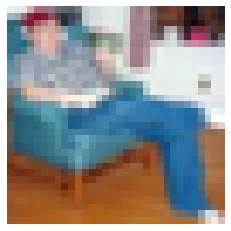

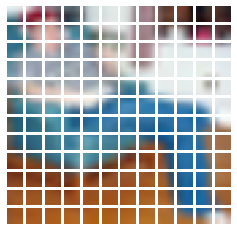

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize= (4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis("off")

어후 팔자좋네 우워있는구나

# Implement the patch encoding layer
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim.  
  
PatchEncoder 레이어는 패치를 projection_dim 크기의 벡터로 투영하여 선형으로 패치를 변환합니다.  
  
In addition, it adds a learnable position embedding to the projected vector.  
  
또한 투영된 벡터에 학습 가능한 위치 임베딩을 추가합니다.

In [21]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim = num_patches, output_dim=projection_dim
    )
  
  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

# Build the ViT model  
  
The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.  
  
ViT 모델은 여러 개의 Transformer 블록으로 구성되어 있으며, 레이어를 사용하여 패치 시퀀스에 자체 주의 메커니즘을 적용합니다.MultiHeadAttention 레이어를 사용합니다. Transformer 블록은 [batch_size, num_patches, projection_dim] 텐서를 생성하며, 이는 softmax가 있는 분류기 헤드를 통해 처리되어 최종 클래스 확률 출력을 생성합니다.  
  
Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with layers.Flatten() and used as the image representation input to the classifier head. Note that the layers.GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.  
  
이미지 표현 역할을 하기 위해 인코딩된 패치 시퀀스에 학습 가능한 임베딩을 추가하는 백서에 설명된 기술과 달리 최종 Transformer 블록의 모든 출력은 layer.Flatten()을 사용하여 재구성되고 이미지 표현 입력으로 사용됩니다. 분류기 머리. layer.GlobalAveragePooling1D 레이어는 Transformer 블록의 출력을 집계하는 데 대신 사용할 수도 있습니다. 특히 패치의 수와 투영 차원이 클 때 그렇습니다.  

In [25]:
def create_vit_classifier():
  inputs = layers.Input(shape=input_shape)
  augmented = data_augmentation(inputs)
  patches = Patches(patch_size)(augmented)
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  for _ in range(transformer_layers):
    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #Create a multihead attention layers
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim = projection_dim, dropout=0.1
    )(x1, x1)
    #스킵커넥션
    x2 = layers.Add()([attention_output,encoded_patches])
    #Layer normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    #MLP
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    #Skip connection 2.
    encoded_patches = layers.Add()([x3, x2])

  #Create a [batch_size, projection_dim] tensor.
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)
  #Add MLP
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
  #Classify outputs
  logits = layers.Dense(num_classes)(features)
  #create the keras model
  model = keras.Model(inputs=inputs, outputs=logits)
  return model

# Compile, train, and evaluate the mode

In [26]:
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
  model.compile(
      optimizer=optimizer,
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
               keras.metrics.SparseCategoricalCrossentropy(name="accuracy"),
               keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
      ],
  )

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor = "val_accuracy",
      save_best_only=True,
      save_weights_only=True,
  )

  history=model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_split=0.1,
      callbacks=[checkpoint_callback],
  )

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(f"Test accuracy:{round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy:{round(top_5_accuracy * 100, 2)}%")
  
  return history

In [27]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 59s 263ms/step - loss: 4.4187 - accuracy: 9.4115 - top-5-accuracy: 0.1720 - val_loss: 3.8439 - val_accuracy: 6.5396 - val_top-5-accuracy: 0.3328
Epoch 2/100
176/176 [==============================] - 44s 250ms/step - loss: 3.7856 - accuracy: 6.8534 - top-5-accuracy: 0.3363 - val_loss: 3.3953 - val_accuracy: 5.6561 - val_top-5-accuracy: 0.4478
Epoch 3/100
176/176 [==============================] - 44s 250ms/step - loss: 3.4776 - accuracy: 6.0151 - top-5-accuracy: 0.4289 - val_loss: 3.1773 - val_accuracy: 5.4039 - val_top-5-accuracy: 0.5110
Epoch 4/100
176/176 [==============================] - 44s 250ms/step - loss: 3.2768 - accuracy: 5.6669 - top-5-accuracy: 0.4857 - val_loss: 3.0118 - val_accuracy: 4.8734 - val_top-5-accuracy: 0.5530
Epoch 5/100
176/176 [==============================] - 44s 250ms/step - loss: 3.1297 - accuracy: 5.4750 - top-5-accuracy: 0.5240 - val_loss: 2.9204 - val_accuracy: 4.7795 - val_top-5-accuracy: 0.5752


엥 실험이 잘못되었네? 어디서 삐꾸가 난건가

100 에포크 후에 ViT 모델은 테스트 데이터에서 약 55%의 정확도와 82%의 상위 5개 정확도를 달성합니다. 동일한 데이터에 대해 처음부터 훈련된 ResNet50V2가 67%의 정확도를 달성할 수 있기 때문에 이는 CIFAR-100 데이터 세트에 대한 경쟁 결과가 아닙니다.  
  
논문에 보고된 최신 결과는 JFT-300M 데이터 세트를 사용하여 ViT 모델을 사전 교육한 다음 대상 데이터 세트에서 미세 조정하여 달성됩니다. 사전 훈련 없이 모델 품질을 향상시키려면 더 많은 에포크에 대해 모델을 훈련시키거나, 더 많은 수의 Transformer 레이어를 사용하거나, 입력 이미지의 크기를 조정하거나, 패치 크기를 변경하거나, 투영 치수를 늘릴 수 있습니다. 또한, 논문에서 언급했듯이 모델의 품질은 아키텍처 선택뿐만 아니라 학습률 일정, 최적화 프로그램, 가중치 감소 등과 같은 매개 변수의 영향을 받습니다. 실제로는 ViT를 미세 조정하는 것이 좋습니다. 대규모 고해상도 데이터 세트를 사용하여 사전 훈련된 모델입니다.
  


In [28]:
!watch nvidia-smi

>